In [ ]:

#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np
import pickle as pkl
import joblib
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint




import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


# Importing Data

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#preparing data set

ravdess = "/content/drive/MyDrive/final_proj_new_ds/speech-emotion-recognition-ravdess-data/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_22', 'Actor_19', 'Actor_23', 'Actor_21', 'Actor_24', 'Actor_20', 'Actor_18', 'Actor_13', 'Actor_16', 'Actor_09', 'Actor_11', 'Actor_10', 'Actor_17', 'Actor_14', 'Actor_12', 'Actor_15', 'Actor_06', 'Actor_04', 'Actor_07', 'Actor_08', 'Actor_05', 'Actor_02', 'Actor_03', 'Actor_01']


In [ ]:
colCrema = "/content/drive/MyDrive/final_proj_new_ds/AudioWAV/"
Tess = "/content/drive/MyDrive/final_proj_new_ds/TESS Toronto emotional speech set data/"

# preprocessing

**Ravdess**

In [ ]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [ ]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-01-01-01-02-01.wav
03
/content/drive/MyDrive/final_proj_new_ds/speech-emotion-recognition-ravdess-data/Actor_22/03-01-01-01-01-02-22.wav
7
03-01-07-02-02-02-01.wav


In [ ]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



  Emotions                                               Path
0  neutral  /content/drive/MyDrive/final_proj_new_ds/speec...
1  neutral  /content/drive/MyDrive/final_proj_new_ds/speec...
2    happy  /content/drive/MyDrive/final_proj_new_ds/speec...
3    happy  /content/drive/MyDrive/final_proj_new_ds/speec...
4  neutral  /content/drive/MyDrive/final_proj_new_ds/speec...
______________________________________________
      Emotions                                               Path
1440  surprise  /content/drive/MyDrive/final_proj_new_ds/speec...
1441  surprise  /content/drive/MyDrive/final_proj_new_ds/speec...
1442   disgust  /content/drive/MyDrive/final_proj_new_ds/speec...
1443  surprise  /content/drive/MyDrive/final_proj_new_ds/speec...
1444   disgust  /content/drive/MyDrive/final_proj_new_ds/speec...
_______________________________________________
neutral     292
happy       193
sad         192
angry       192
fear        192
surprise    192
disgust     192
Name: Emotions, dtype: in

**Crema DataFrame**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [ ]:
crema_directory_list = os.listdir(colCrema)
print(colCrema)
file_emotion = []
file_path = []
print(crema_directory_list)
for file in crema_directory_list:
    # storing file paths

    file_path.append(colCrema + file)

    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
print(file_path[:3])

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


/content/drive/MyDrive/final_proj_new_ds/AudioWAV/
['1079_TSI_ANG_XX.wav', '1079_TAI_DIS_XX.wav', '1079_TIE_SAD_XX.wav', '1079_TIE_HAP_XX.wav', '1079_MTI_SAD_XX.wav', '1079_TSI_DIS_XX.wav', '1079_TAI_SAD_XX.wav', '1079_TIE_ANG_XX.wav', '1080_DFA_SAD_XX.wav', '1080_IEO_ANG_LO.wav', '1079_TSI_SAD_XX.wav', '1079_WSI_ANG_XX.wav', '1080_DFA_NEU_XX.wav', '1080_IEO_ANG_HI.wav', '1079_WSI_NEU_XX.wav', '1079_WSI_FEA_XX.wav', '1079_TSI_NEU_XX.wav', '1079_WSI_HAP_XX.wav', '1079_WSI_DIS_XX.wav', '1080_DFA_FEA_XX.wav', '1080_DFA_DIS_XX.wav', '1080_DFA_HAP_XX.wav', '1079_WSI_SAD_XX.wav', '1080_DFA_ANG_XX.wav', '1080_IEO_FEA_MD.wav', '1080_IEO_DIS_MD.wav', '1080_IEO_HAP_HI.wav', '1080_IEO_DIS_LO.wav', '1080_IEO_DIS_HI.wav', '1080_IEO_FEA_HI.wav', '1080_IEO_SAD_HI.wav', '1080_IEO_HAP_LO.wav', '1080_IEO_ANG_MD.wav', '1080_IEO_SAD_LO.wav', '1080_IEO_HAP_MD.wav', '1080_IEO_FEA_LO.wav', '1080_IEO_NEU_XX.wav', '1080_IOM_DIS_XX.wav', '1080_ITH_DIS_XX.wav', '1080_IOM_NEU_XX.wav', '1080_ITH_NEU_XX.wav', '1080

**TESS dataset**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


sad         400
fear        400
surprise    400
neutral     400
disgust     400
happy       400
angry       400
Name: Emotions, dtype: int64


**Integration**

In [ ]:
data_path = pd.concat([ravdess_df, Crema_df, Tess_df], axis = 0)
data_path.to_csv("/content/drive/MyDrive/final_proj_new_ds/data_path_new_mz.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/final_proj_new_ds/speec...
1,neutral,/content/drive/MyDrive/final_proj_new_ds/speec...
2,happy,/content/drive/MyDrive/final_proj_new_ds/speec...
3,happy,/content/drive/MyDrive/final_proj_new_ds/speec...
4,neutral,/content/drive/MyDrive/final_proj_new_ds/speec...


In [ ]:

print(data_path.Emotions.value_counts())


happy       1864
sad         1863
angry       1863
fear        1863
disgust     1863
neutral     1779
surprise     592
Name: Emotions, dtype: int64


>*                           Data Visualisation and Exploration

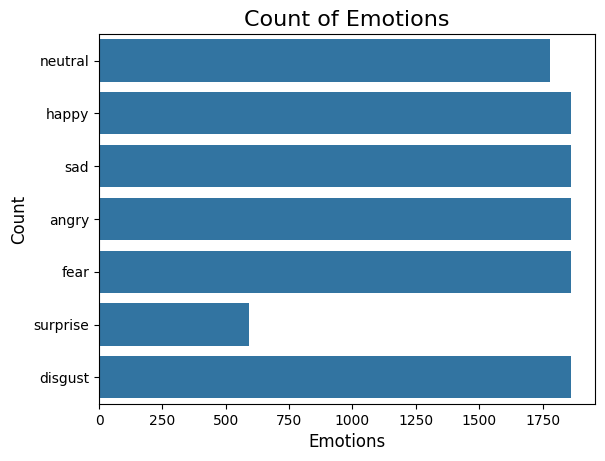

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.show()

In [ ]:
data,sr = librosa.load(file_path[0])
sr

22050

In [ ]:
ipd.Audio(data,rate=sr)

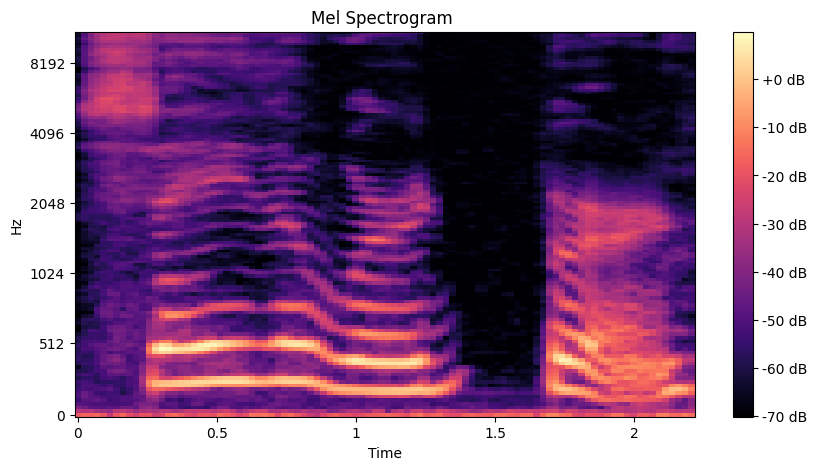

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

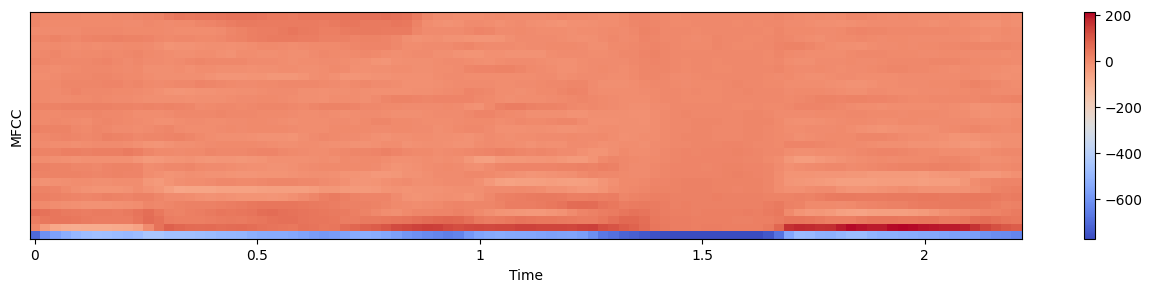

In [ ]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

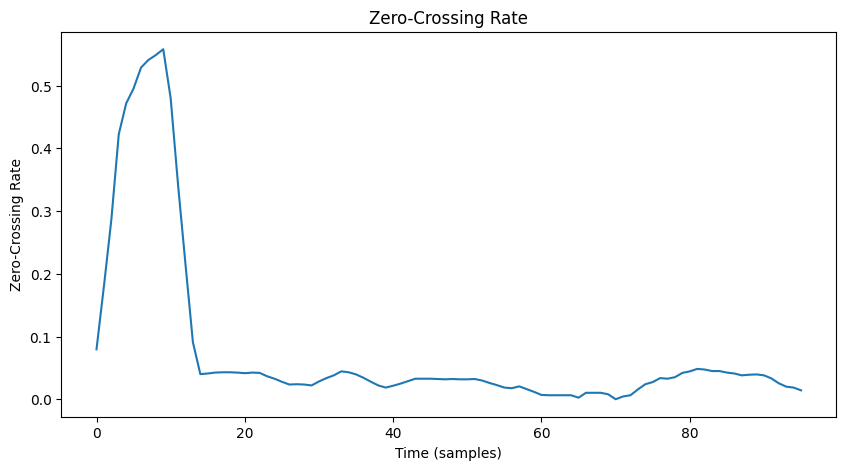

In [ ]:
# prompt: plot zcr(zero-cepstral-rate)for an audio file

import librosa
import matplotlib.pyplot as plt

# Load the audio file
data, sr = librosa.load(file_path[0])

# Calculate the zero-crossing rate
zcr = librosa.feature.zero_crossing_rate(data)

# Plot the zero-crossing rate
plt.figure(figsize=(10, 5))
plt.plot(zcr[0])
plt.title('Zero-Crossing Rate')
plt.xlabel('Time (samples)')
plt.ylabel('Zero-Crossing Rate')
plt.show()






# Data Augumentation

In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(a=data, shift=shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

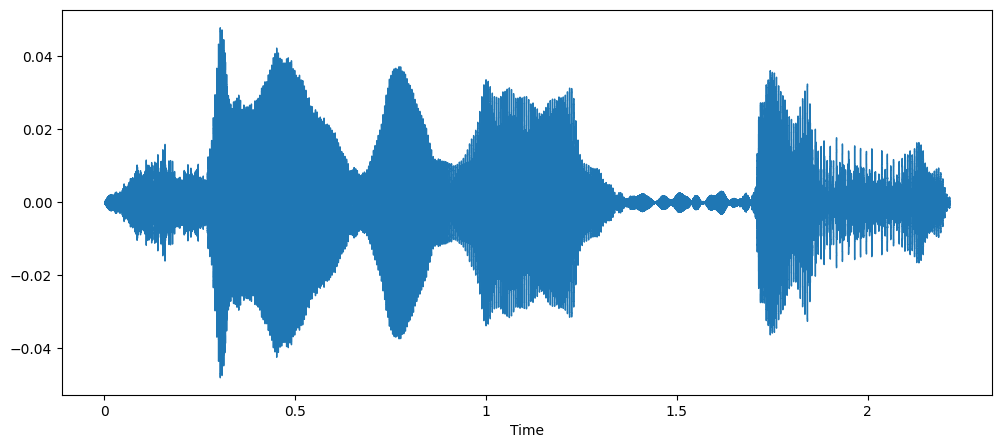

In [ ]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

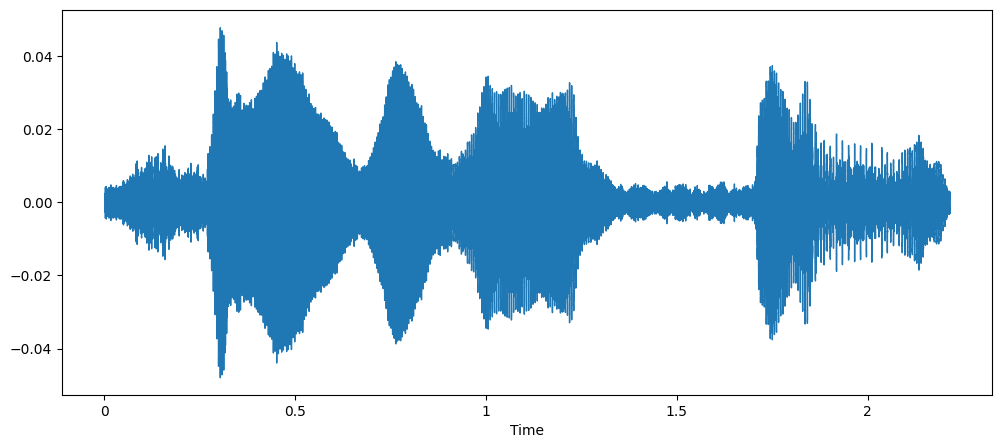

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

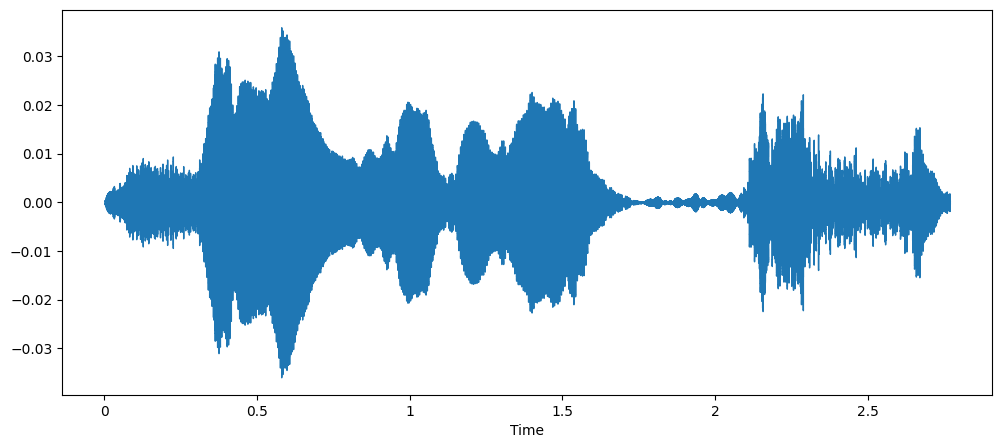

In [ ]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

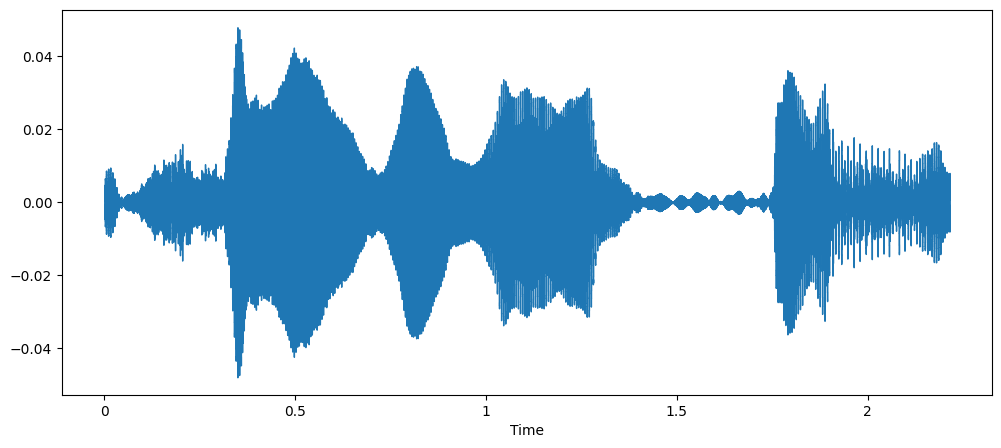

In [ ]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

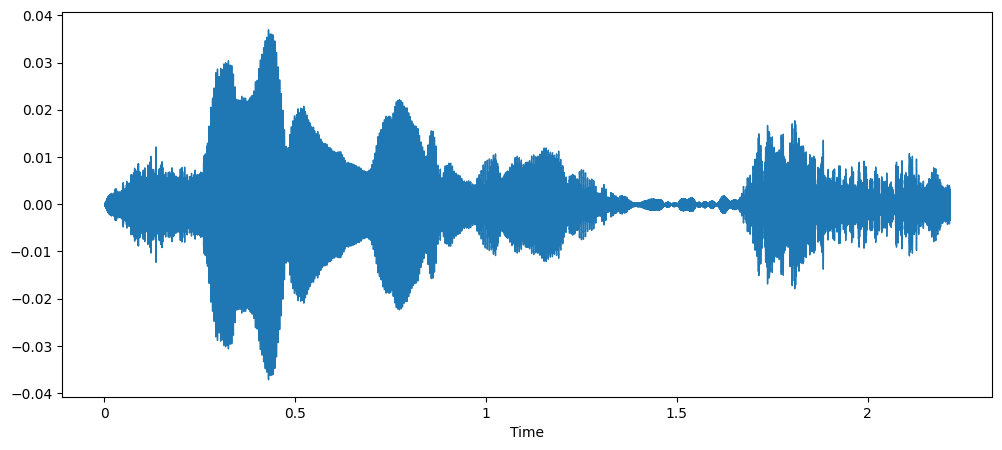

In [ ]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                       zcr(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    print(aud.shape)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    print(aud2.shape)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    print(aud3.shape)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    print(aud4.shape)
    audio=np.vstack((audio,aud4))




    return audio


In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [ ]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):

    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

In [ ]:
len(X), len(Y), data_path.Path.shape


(9639, 9639, (11687,))

# Saving features

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
#Emotions.to_csv('/content/drive/MyDrive/df_mfcc_zcr -with stretch.csv', index=False)
Emotions.head()

,0,Emotions
0,0.174805,neutral
1,0.245117,neutral
2,0.302246,neutral
3,0.256348,neutral
4,0.240723,neutral


In [ ]:
Emotions = pd.read_csv('/content/drive/MyDrive/new/df_mfcc_zcr.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2259,2260,2261,2262,2263,2264,2265,2266,2267,Emotions
0,0.174805,0.245117,0.302246,0.256348,0.240723,0.238281,0.249023,0.271973,0.321289,0.397461,...,-0.698600,-0.266977,0.375091,1.035953,1.524876,1.703911,1.526763,1.047194,0.393317,neutral
1,0.257812,0.383789,0.514160,0.513184,0.507324,0.509277,0.507324,0.506348,0.501465,0.505859,...,0.252436,-1.214293,-3.915850,-0.008794,0.532109,-1.848152,0.983020,0.116217,-5.099155,neutral
2,0.161133,0.235352,0.308594,0.276855,0.258301,0.232422,0.199219,0.187012,0.195801,0.215332,...,1.102755,0.788114,0.527006,0.312680,0.136805,-0.008665,-0.129917,-0.230166,-0.309249,neutral
3,0.250977,0.375977,0.494141,0.500000,0.498047,0.488281,0.495605,0.492188,0.488770,0.504395,...,-3.114733,-2.484539,1.599632,-4.890743,1.793692,0.083030,-0.908131,0.399756,-0.213514,neutral
4,0.198730,0.296387,0.386230,0.369141,0.354980,0.377441,0.446777,0.500488,0.581543,0.616699,...,1.324190,9.985184,8.326422,3.818900,3.945398,4.357159,6.712245,6.481177,0.486208,neutral


In [ ]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2264         True
2265         True
2266         True
2267         True
Emotions    False
Length: 2269, dtype: bool


In [ ]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2264        False
2265        False
2266        False
2267        False
Emotions    False
Length: 2269, dtype: bool


(46748, 2269)

In [ ]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2264        0
2265        0
2266        0
2267        0
Emotions    0
Length: 2269, dtype: int64

# Data preparation

In [ ]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [ ]:
print(Y.shape)
X.shape

(46748, 7)


(46748, 2268)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37398, 2268), (37398, 7), (9350, 2268), (9350, 7))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37398, 2268), (37398, 7), (9350, 2268), (9350, 7))

In [ ]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping for all models


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau


In [ ]:

early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# CNN LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LSTM, Bidirectional, Reshape
from keras.regularizers import l2

def create_model():
    model = Sequential()
    model.add(Reshape((2268, 1, 1), input_shape=(2268,)))  # Reshape for 2D convolution

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 1), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 1), padding='same'))
    model.add(BatchNormalization())

    # Reshape for LSTM
    model.add(Reshape((567, 256)))  # Adjusted reshape operation

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))

    model.add(Dense(7, activation='softmax'))

    return model


In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
from keras import models

with strategy.scope():
  model = models.load_model('/content/drive/MyDrive/new/new2d8.h5')
  #model.compile(loss='categorical_crossentropy', optimizer='adam',metrics='accuracy')


In [ ]:
# @title Default title text
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2268, 1, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 2268, 1, 512)      5120      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1134, 1, 512)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 1134, 1, 512)     2048      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 1134, 1, 256)      1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 567, 1, 256)      0

In [ ]:
hist001=model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test),callbacks=[early_stop,lr_reduction])

Epoch 1/30
585/585 [==============================] - 227s 360ms/step - loss: 2.1097 - accuracy: 0.2844 - val_loss: 2.0347 - val_accuracy: 0.2247 - lr: 0.0010
Epoch 2/30
585/585 [==============================] - 197s 337ms/step - loss: 1.6255 - accuracy: 0.3731 - val_loss: 1.5392 - val_accuracy: 0.4045 - lr: 0.0010
Epoch 3/30
585/585 [==============================] - 198s 338ms/step - loss: 1.5441 - accuracy: 0.4134 - val_loss: 1.5522 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 4/30
585/585 [==============================] - 197s 337ms/step - loss: 1.4865 - accuracy: 0.4422 - val_loss: 1.4192 - val_accuracy: 0.4701 - lr: 0.0010
Epoch 5/30
585/585 [==============================] - 197s 337ms/step - loss: 1.4263 - accuracy: 0.4758 - val_loss: 1.3535 - val_accuracy: 0.4986 - lr: 0.0010
Epoch 6/30
585/585 [==============================] - 197s 337ms/step - loss: 1.3797 - accuracy: 0.4894 - val_loss: 1.2946 - val_accuracy: 0.5187 - lr: 0.0010
Epoch 7/30
585/585 [==========================

In [ ]:
model.save('/content/drive/MyDrive/new2d1.h5')

In [ ]:
import pickle

with open('/content/drive/MyDrive/2dcnnhist1.pkl', 'wb') as f:
  pickle.dump(hist001.history, f)

In [ ]:
hist002=model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_test, y_test),callbacks=[early_stop,lr_reduction])

Epoch 1/20
585/585 [==============================] - 198s 339ms/step - loss: 0.8360 - accuracy: 0.7216 - val_loss: 0.9336 - val_accuracy: 0.6748 - lr: 0.0010
Epoch 2/20
585/585 [==============================] - 197s 337ms/step - loss: 0.8169 - accuracy: 0.7306 - val_loss: 0.9283 - val_accuracy: 0.6740 - lr: 0.0010
Epoch 3/20
585/585 [==============================] - 197s 337ms/step - loss: 0.7970 - accuracy: 0.7345 - val_loss: 0.9037 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 4/20
585/585 [==============================] - 198s 338ms/step - loss: 0.7729 - accuracy: 0.7490 - val_loss: 0.8614 - val_accuracy: 0.7058 - lr: 0.0010
Epoch 5/20
585/585 [==============================] - 197s 337ms/step - loss: 0.7616 - accuracy: 0.7500 - val_loss: 0.8906 - val_accuracy: 0.7003 - lr: 0.0010
Epoch 6/20
585/585 [==============================] - 197s 337ms/step - loss: 0.7474 - accuracy: 0.7563 - val_loss: 0.8717 - val_accuracy: 0.7062 - lr: 0.0010
Epoch 7/20
585/585 [==========================

In [ ]:
model.save('/content/drive/MyDrive/new2d2.h5')

In [ ]:
import pickle

with open('/content/drive/MyDrive/2dcnnhist2.pkl', 'wb') as f:
  pickle.dump(hist002.history, f)

In [ ]:
hist003=model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test),callbacks=[early_stop,lr_reduction])

Epoch 1/10
293/293 [==============================] - 179s 567ms/step - loss: 0.3602 - accuracy: 0.8968 - val_loss: 0.7124 - val_accuracy: 0.7864 - lr: 5.0000e-04
Epoch 2/10
293/293 [==============================] - 151s 515ms/step - loss: 0.3448 - accuracy: 0.9029 - val_loss: 0.7143 - val_accuracy: 0.7912 - lr: 5.0000e-04
Epoch 3/10
293/293 [==============================] - 151s 514ms/step - loss: 0.3320 - accuracy: 0.9059 - val_loss: 0.7124 - val_accuracy: 0.7898 - lr: 5.0000e-04
Epoch 4/10
293/293 [==============================] - 151s 514ms/step - loss: 0.3310 - accuracy: 0.9062 - val_loss: 0.6960 - val_accuracy: 0.7920 - lr: 5.0000e-04
Epoch 5/10
293/293 [==============================] - 150s 514ms/step - loss: 0.3206 - accuracy: 0.9090 - val_loss: 0.7289 - val_accuracy: 0.7917 - lr: 5.0000e-04
Epoch 6/10
293/293 [==============================] - 151s 514ms/step - loss: 0.3161 - accuracy: 0.9110 - val_loss: 0.7159 - val_accuracy: 0.7975 - lr: 5.0000e-04
Epoch 7/10
293/293 [==

In [ ]:
model.save('/content/drive/MyDrive/new2d3.h5')

In [ ]:
import pickle

with open('/content/drive/MyDrive/2dcnnhist3.pkl', 'wb') as f:
  pickle.dump(hist003.history, f)

In [ ]:
hist004=model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test),callbacks=[early_stop,lr_reduction])

Epoch 1/10
585/585 [==============================] - 205s 341ms/step - loss: 0.3056 - accuracy: 0.9179 - val_loss: 0.7063 - val_accuracy: 0.7998 - lr: 2.5000e-04
Epoch 2/10
585/585 [==============================] - 197s 336ms/step - loss: 0.2932 - accuracy: 0.9211 - val_loss: 0.6870 - val_accuracy: 0.8088 - lr: 2.5000e-04
Epoch 3/10
585/585 [==============================] - 196s 335ms/step - loss: 0.2854 - accuracy: 0.9230 - val_loss: 0.6665 - val_accuracy: 0.8119 - lr: 2.5000e-04
Epoch 4/10
585/585 [==============================] - 196s 335ms/step - loss: 0.2775 - accuracy: 0.9254 - val_loss: 0.7152 - val_accuracy: 0.8052 - lr: 2.5000e-04
Epoch 5/10
585/585 [==============================] - 196s 335ms/step - loss: 0.2696 - accuracy: 0.9285 - val_loss: 0.6793 - val_accuracy: 0.8116 - lr: 2.5000e-04
Epoch 6/10
585/585 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.9291
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
585/585 [====

In [ ]:
model.save('/content/drive/MyDrive//new/new2d4.h5')

In [ ]:
import pickle

with open('/content/drive/MyDrive/new/2dcnnhist4.pkl', 'wb') as f:
  pickle.dump(hist004.history, f)

In [ ]:
hist005=model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test),callbacks=[early_stop,lr_reduction])

Epoch 1/10
585/585 [==============================] - 197s 338ms/step - loss: 0.2215 - accuracy: 0.9434 - val_loss: 0.6867 - val_accuracy: 0.8187 - lr: 1.2500e-04
Epoch 2/10
585/585 [==============================] - 197s 336ms/step - loss: 0.2159 - accuracy: 0.9449 - val_loss: 0.6960 - val_accuracy: 0.8165 - lr: 1.2500e-04
Epoch 3/10
585/585 [==============================] - 197s 336ms/step - loss: 0.2113 - accuracy: 0.9465 - val_loss: 0.6915 - val_accuracy: 0.8195 - lr: 1.2500e-04
Epoch 4/10
585/585 [==============================] - 197s 336ms/step - loss: 0.2132 - accuracy: 0.9459 - val_loss: 0.6926 - val_accuracy: 0.8206 - lr: 1.2500e-04
Epoch 5/10
585/585 [==============================] - 197s 336ms/step - loss: 0.2063 - accuracy: 0.9476 - val_loss: 0.7010 - val_accuracy: 0.8219 - lr: 1.2500e-04
Epoch 6/10
585/585 [==============================] - 196s 335ms/step - loss: 0.2047 - accuracy: 0.9487 - val_loss: 0.7072 - val_accuracy: 0.8212 - lr: 1.2500e-04
Epoch 7/10
585/585 [==

In [ ]:
model.save('/content/drive/MyDrive/new/new2d5.h5')

In [ ]:
import pickle

with open('/content/drive/MyDrive/new/2dcnnhist5.pkl', 'wb') as f:
  pickle.dump(hist005.history, f)

In [ ]:
hist006=model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test),callbacks=[early_stop,lr_reduction])

Epoch 1/5
585/585 [==============================] - 198s 339ms/step - loss: 0.1927 - accuracy: 0.9515 - val_loss: 0.6898 - val_accuracy: 0.8243 - lr: 1.2500e-04
Epoch 2/5
585/585 [==============================] - 196s 336ms/step - loss: 0.1929 - accuracy: 0.9533 - val_loss: 0.7038 - val_accuracy: 0.8221 - lr: 1.2500e-04
Epoch 3/5
585/585 [==============================] - 196s 336ms/step - loss: 0.1887 - accuracy: 0.9536 - val_loss: 0.6945 - val_accuracy: 0.8267 - lr: 1.2500e-04
Epoch 4/5
585/585 [==============================] - 197s 337ms/step - loss: 0.1879 - accuracy: 0.9534 - val_loss: 0.6960 - val_accuracy: 0.8302 - lr: 1.2500e-04
Epoch 5/5
585/585 [==============================] - 196s 335ms/step - loss: 0.1870 - accuracy: 0.9545 - val_loss: 0.6877 - val_accuracy: 0.8261 - lr: 1.2500e-04


In [ ]:
model.save('/content/drive/MyDrive/new/new2d6.h5')

In [ ]:
with open('/content/drive/MyDrive/new/2dcnnhist6.pkl', 'wb') as f:
  pickle.dump(hist006.history, f)

In [ ]:
hist007=model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test),callbacks=[early_stop,lr_reduction])

Epoch 1/5
585/585 [==============================] - 198s 338ms/step - loss: 0.1819 - accuracy: 0.9560 - val_loss: 0.6765 - val_accuracy: 0.8309 - lr: 1.2500e-04
Epoch 2/5
585/585 [==============================] - 196s 335ms/step - loss: 0.1829 - accuracy: 0.9551 - val_loss: 0.6960 - val_accuracy: 0.8236 - lr: 1.2500e-04
Epoch 3/5
585/585 [==============================] - 196s 335ms/step - loss: 0.1849 - accuracy: 0.9553 - val_loss: 0.6911 - val_accuracy: 0.8277 - lr: 1.2500e-04
Epoch 4/5
585/585 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9561
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
585/585 [==============================] - 197s 336ms/step - loss: 0.1791 - accuracy: 0.9561 - val_loss: 0.7100 - val_accuracy: 0.8252 - lr: 1.2500e-04
Epoch 5/5
585/585 [==============================] - 197s 337ms/step - loss: 0.1688 - accuracy: 0.9597 - val_loss: 0.6995 - val_accuracy: 0.8281 - lr: 6.2500e-05


In [ ]:
with open('/content/drive/MyDrive/new/2dcnnhist7.pkl', 'wb') as f:
  pickle.dump(hist007.history, f)

In [ ]:
hist008=model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test),callbacks=[early_stop,lr_reduction])

Epoch 1/5
585/585 [==============================] - 197s 337ms/step - loss: 0.1632 - accuracy: 0.9617 - val_loss: 0.7090 - val_accuracy: 0.8305 - lr: 6.2500e-05
Epoch 2/5
585/585 [==============================] - 196s 336ms/step - loss: 0.1645 - accuracy: 0.9613 - val_loss: 0.7199 - val_accuracy: 0.8271 - lr: 6.2500e-05
Epoch 3/5
585/585 [==============================] - 196s 336ms/step - loss: 0.1593 - accuracy: 0.9622 - val_loss: 0.7010 - val_accuracy: 0.8325 - lr: 6.2500e-05
Epoch 4/5
585/585 [==============================] - 196s 336ms/step - loss: 0.1602 - accuracy: 0.9623 - val_loss: 0.7163 - val_accuracy: 0.8274 - lr: 6.2500e-05
Epoch 5/5
585/585 [==============================] - 197s 336ms/step - loss: 0.1576 - accuracy: 0.9638 - val_loss: 0.7039 - val_accuracy: 0.8310 - lr: 6.2500e-05


In [ ]:
model.save('/content/drive/MyDrive/new/new2d8.h5')

In [ ]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/new/2dcnnhist1.pkl', 'rb') as fp:
  hist1=pickle.load(fp)
with open('/content/drive/MyDrive/new/2dcnnhist2.pkl', 'rb') as fp:
  hist2=pickle.load(fp)
'''with open('/content/drive/MyDrive/new/2dcnnhist3.pkl', 'rb') as fp:
  hist3=pickle.load(fp)'''
with open('/content/drive/MyDrive/new/2dcnnhist4.pkl','rb') as fp:
  hist4=pickle.load(fp)
with open('/content/drive/MyDrive/new/2dcnnhist5.pkl', 'rb') as fp:
  hist5=pickle.load(fp)
with open('/content/drive/MyDrive/new/2dcnnhist6.pkl', 'rb') as fp:
  hist6=pickle.load(fp)
with open('/content/drive/MyDrive/new/2dcnnhist7.pkl', 'rb') as fp:
  hist7=pickle.load(fp)
with open('/content/drive/MyDrive/new/2dcnnhist8.pkl', 'rb') as fp:
  hist8=pickle.load(fp)

293/293 [==============================] - 15s 47ms/step - loss: 0.7042 - accuracy: 0.8303
Accuracy of our model on test data :  83.02673697471619 %


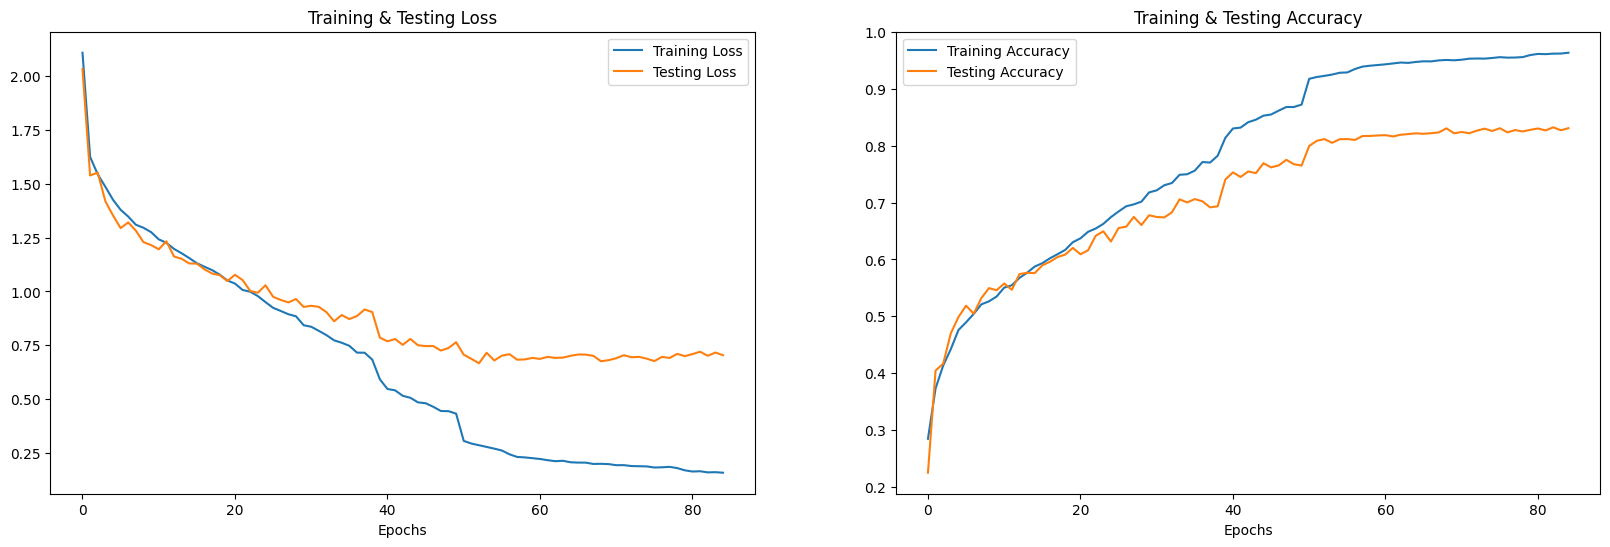

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
epochs = [i for i in range(85)]
fig , ax = plt.subplots(1,2)
train_acc = hist1['accuracy']+hist2['accuracy']+hist4['accuracy']+hist5['accuracy']+hist6['accuracy']+hist7['accuracy']+hist8['accuracy']
train_loss = hist1['loss']+hist2['loss']+hist4['loss']+hist5['loss']+hist6['loss']+hist7['loss']+hist8['loss']
test_loss = hist1['val_loss']+hist2['val_loss']+hist4['val_loss']+hist5['val_loss']+hist6['val_loss']+hist7['val_loss']+hist8['val_loss']
test_acc=hist1['val_accuracy']+hist2['val_accuracy']+hist4['val_accuracy']+hist5['val_accuracy']+hist6['val_accuracy']+hist7['val_accuracy']+hist8['val_accuracy']
fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test= model.predict(x_test)
y_pred00 = encoder.inverse_transform(pred_test)
y_test00 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred00.flatten()
df0['Actual Labels'] = y_test00.flatten()

df0.head(10)

293/293 [==============================] - 19s 54ms/step


,Predicted Labels,Actual Labels
0,sad,sad
1,neutral,neutral
2,angry,disgust
3,sad,sad
4,fear,happy
5,disgust,sad
6,angry,angry
7,neutral,neutral
8,disgust,sad
9,sad,sad


# Evalutation

<ipython-input-26-665820a043f4>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


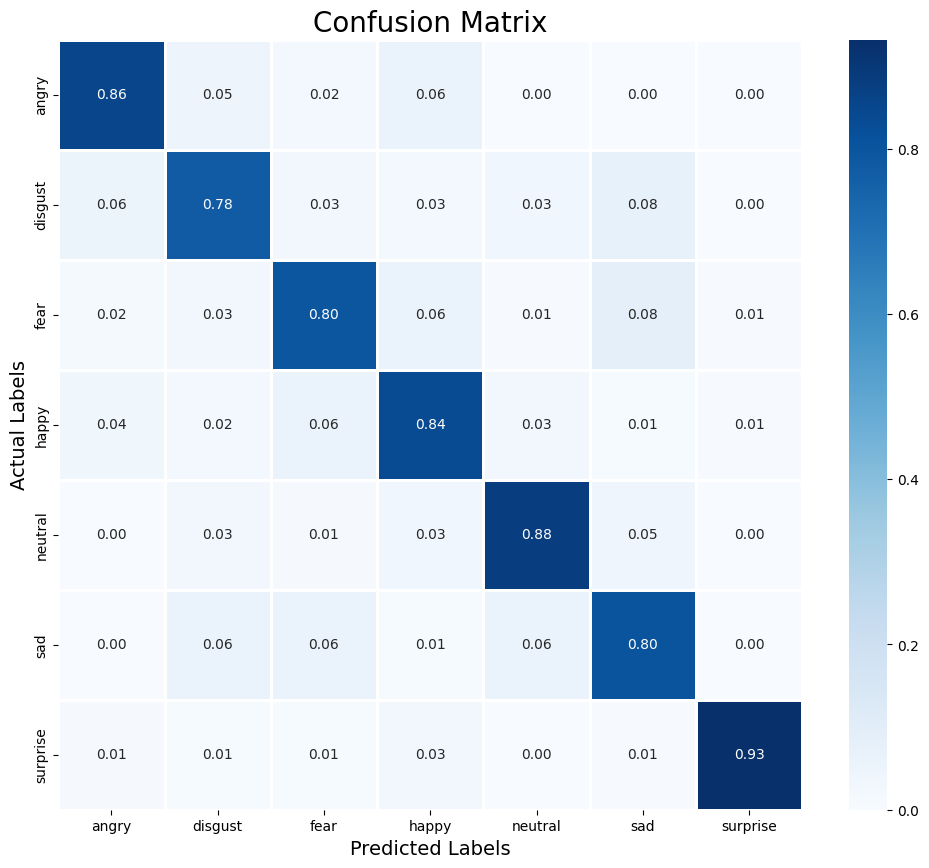

              precision    recall  f1-score   support

       angry       0.88      0.86      0.87      1484
     disgust       0.81      0.78      0.79      1511
        fear       0.80      0.80      0.80      1457
       happy       0.80      0.84      0.82      1469
     neutral       0.86      0.88      0.87      1444
         sad       0.79      0.80      0.80      1514
    surprise       0.94      0.93      0.94       471

    accuracy                           0.83      9350
   macro avg       0.84      0.84      0.84      9350
weighted avg       0.83      0.83      0.83      9350



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test00, y_pred00)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test00, y_pred00))

In [ ]:
# predicting on test data.
pred_test= model.predict(x_train)
y_pred001 = encoder.inverse_transform(pred_test)
y_test001 = encoder.inverse_transform(y_train)

# Check for random predictions
df1 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df1['Predicted Labels'] = y_pred00.flatten()
df1['Actual Labels'] = y_test00.flatten()

df1.head(10)

1169/1169 [==============================] - 50s 42ms/step


,Predicted Labels,Actual Labels
0,sad,sad
1,neutral,neutral
2,angry,disgust
3,sad,sad
4,fear,happy
5,disgust,sad
6,angry,angry
7,neutral,neutral
8,disgust,sad
9,sad,sad


<ipython-input-28-ec8399f19f07>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


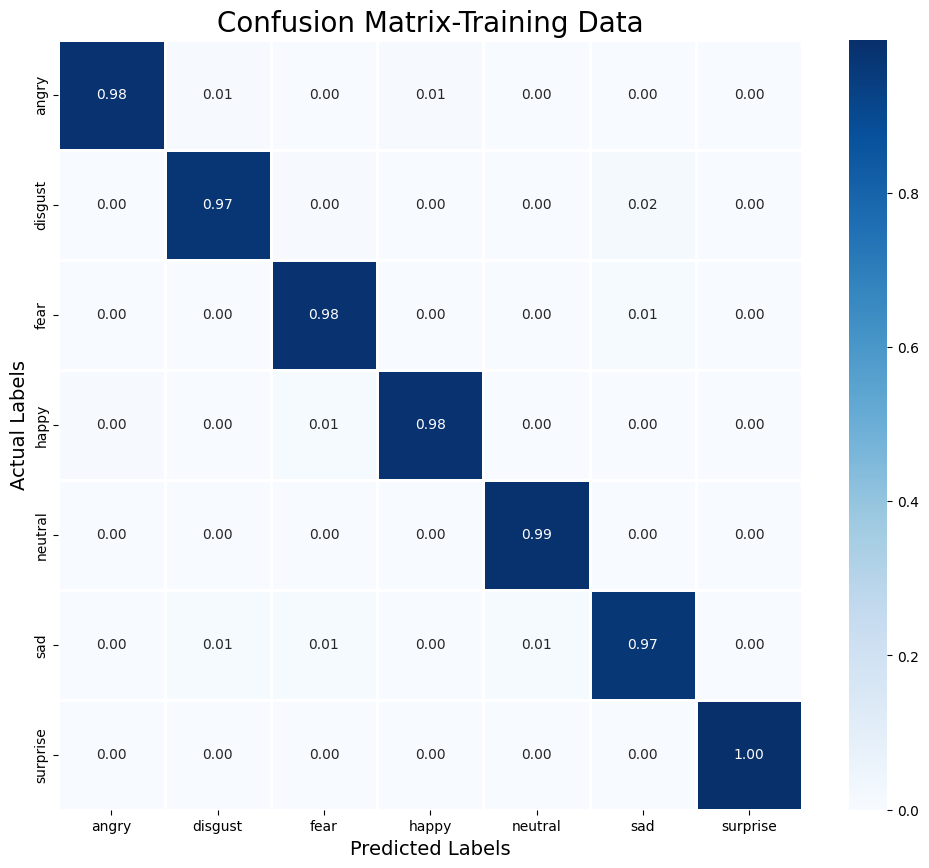

              precision    recall  f1-score   support

       angry       0.99      0.98      0.99      5968
     disgust       0.98      0.97      0.97      5941
        fear       0.97      0.98      0.98      5995
       happy       0.99      0.98      0.98      5987
     neutral       0.99      0.99      0.99      5672
         sad       0.97      0.97      0.97      5938
    surprise       0.99      1.00      1.00      1897

    accuracy                           0.98     37398
   macro avg       0.98      0.98      0.98     37398
weighted avg       0.98      0.98      0.98     37398



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test001, y_pred001)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix-Training Data', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test001, y_pred001))

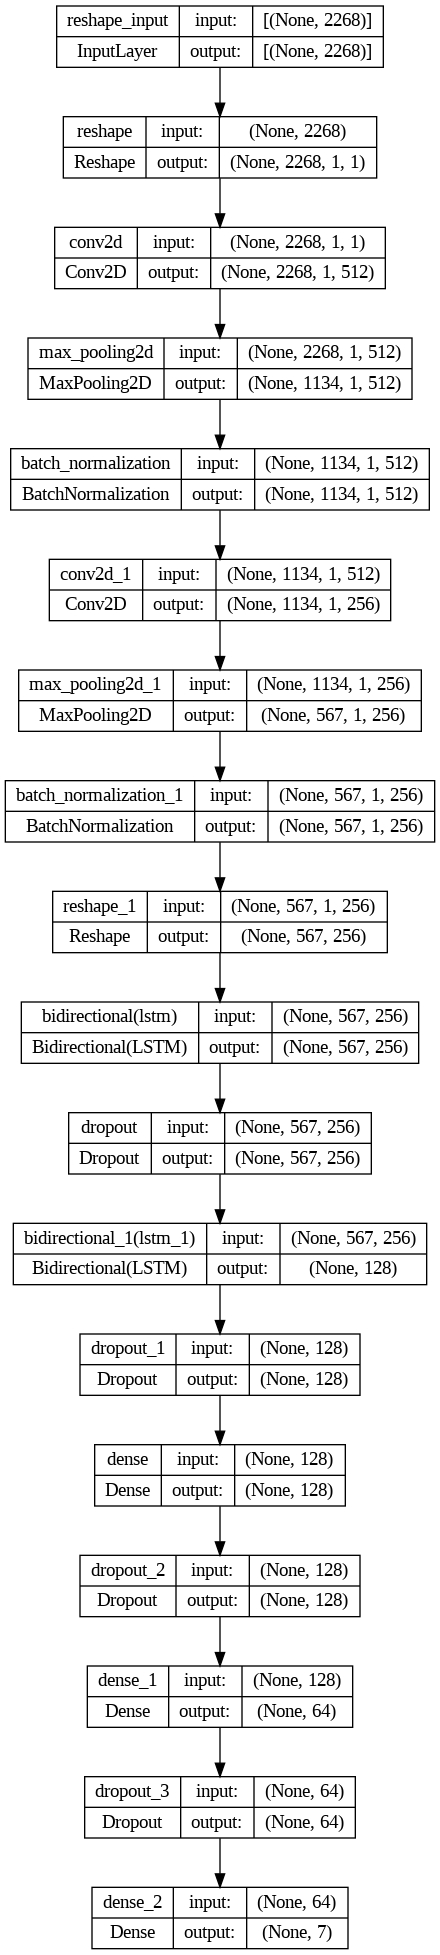

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/new/model_img.png', show_shapes=True)

In [ ]:
df_tess=pd.read_csv('/content/drive/MyDrive/new/Copy of df_tess')
df_ravdess=pd.read_csv('/content/drive/MyDrive/new/Copy of df_ravdess')
df_crema=pd.read_csv('/content/drive/MyDrive/new/Copy of df_crema')

In [ ]:
def prep(df,k):
  l=['rav-dess','tess','crema']
  print(l[k])
  print(df.isna().any())
  df=df.fillna(0)
  print(df.isna().any())
  df.shape
  np.sum(df.isna())
  X = df.iloc[: ,:-1].values
  Y = df['Emotions'].values
  Y = encoder.transform(np.array(Y).reshape(-1,1)).toarray()
  x_tra = scaler.transform(X)
  return x_tra,Y

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
b=np.array(['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad'],dtype=object)

In [ ]:
b

array(['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [ ]:
print(encoder.categories_)

[array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)]


rav-dess
0           False
1           False
2           False
3           False
4           False
            ...  
2264         True
2265         True
2266         True
2267         True
Emotions    False
Length: 2269, dtype: bool
0           False
1           False
2           False
3           False
4           False
            ...  
2264        False
2265        False
2266        False
2267        False
Emotions    False
Length: 2269, dtype: bool
46/46 [==============================] - 3s 42ms/step


              precision    recall  f1-score   support

       angry       0.96      0.96      0.96       192
     disgust       0.95      0.97      0.96       192
        fear       0.93      0.91      0.92       192
       happy       0.89      0.95      0.92       193
     neutral       0.98      0.96      0.97       292
         sad       0.93      0.91      0.92       192
    surprise       0.96      0.96      0.96       192

    accuracy                           0.95      1445

<ipython-input-42-815cead47d03>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


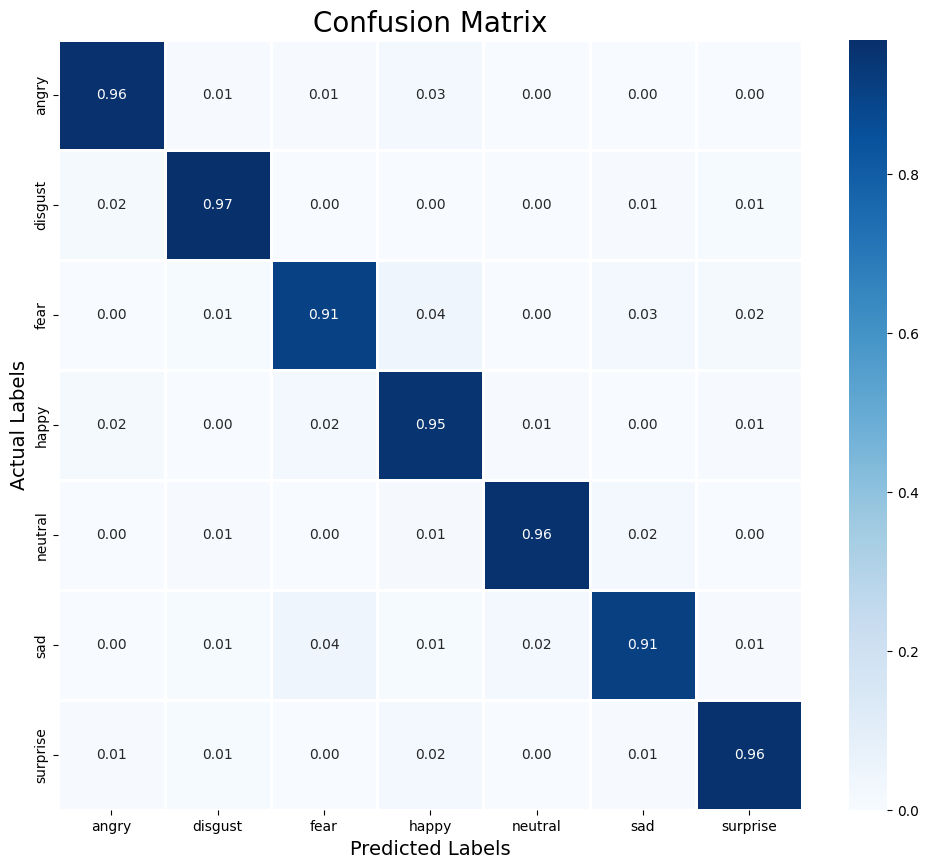

tess
0           False
1           False
2           False
3           False
4           False
            ...  
2264        False
2265        False
2266        False
2267        False
Emotions    False
Length: 2269, dtype: bool
0           False
1           False
2           False
3           False
4           False
            ...  
2264        False
2265        False
2266        False
2267        False
Emotions    False
Length: 2269, dtype: bool
88/88 [==============================] - 5s 42ms/step


              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       400
     disgust       1.00      1.00      1.00       400
        fear       1.00      1.00      1.00       400
       happy       1.00      1.00      1.00       400
     neutral       1.00      1.00      1.00       400
         sad       1.00      1.00      1.00       400
    surprise       1.00      1.00      1.00       400

    accuracy                           1.00      2800
   

<ipython-input-42-815cead47d03>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


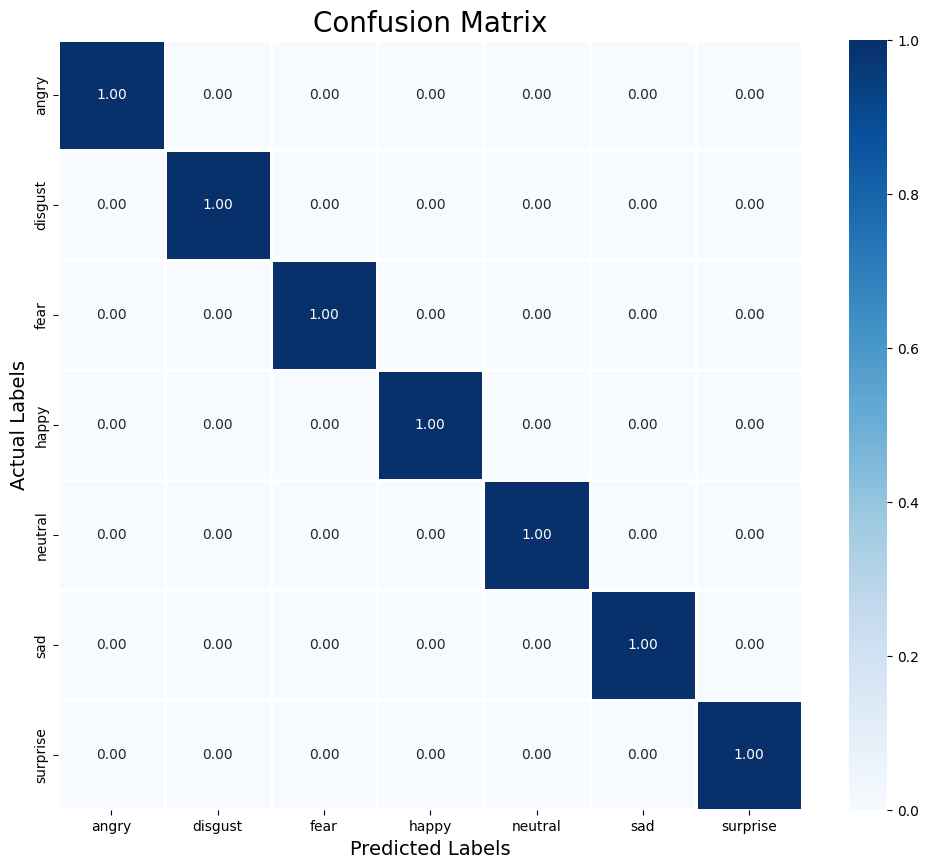

crema
0           False
1           False
2           False
3           False
4           False
            ...  
2264         True
2265         True
2266         True
2267         True
Emotions    False
Length: 2269, dtype: bool
0           False
1           False
2           False
3           False
4           False
            ...  
2264        False
2265        False
2266        False
2267        False
Emotions    False
Length: 2269, dtype: bool
233/233 [==============================] - 10s 41ms/step


              precision    recall  f1-score   support

       angry       0.97      0.96      0.96      1271
     disgust       0.93      0.92      0.93      1271
        fear       0.93      0.95      0.94      1271
       happy       0.94      0.94      0.94      1271
     neutral       0.96      0.95      0.95      1087
         sad       0.92      0.93      0.92      1271

    accuracy                           0.94      7442
   macro avg       0.94      0.94      0.94      7442

<ipython-input-42-815cead47d03>:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


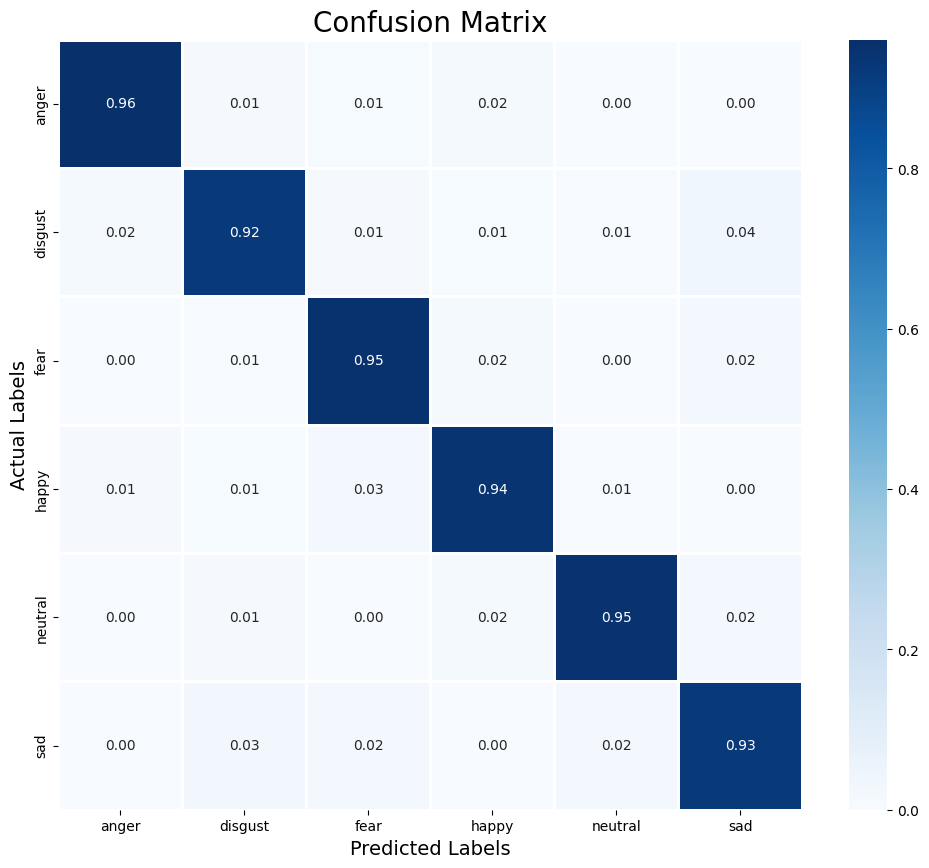

In [ ]:
for k,i in enumerate([df_ravdess,df_tess,df_crema]):
  x,y=prep(i,k)
  # predicting on test data.
  pred_test= model.predict(x)
  y_pred00 = encoder.inverse_transform(pred_test)
  y_test00 = encoder.inverse_transform(y)

  # Check for random predictions
  df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
  df0['Predicted Labels'] = y_pred00.flatten()
  df0['Actual Labels'] = y_test00.flatten()

  df0.head(10)
  print()
  print()
  print(classification_report(y_test00, y_pred00),end='\n\n\n------------------\n')

  cm = confusion_matrix(y_test00, y_pred00)
  plt.figure(figsize = (12, 10))
  a=encoder.categories_
  if k==2:
    a=b
  cm = pd.DataFrame(cm , index = [i for i in a] , columns = [i for i in a])
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
  plt.title('Confusion Matrix', size=20)
  plt.xlabel('Predicted Labels', size=14)
  plt.ylabel('Actual Labels', size=14)
  plt.show()
